## Data Preparation

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sentence_splitter import SentenceSplitter
import matplotlib.pyplot as plt
import os
import ast
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from focal_loss import SparseCategoricalFocalLoss

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-05-31 15:15:55.725743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 15:15:59.453132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-05-31 15:16:06.178178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [4]:
# data_1 = pd.read_csv("ETD_data.csv")
# data_1['text'] = data_1['text'].astype(str)
# data_1
# train_image = pd.read_csv("trainETD500.csv")
# data_2 = train_image.drop(columns = 'labels')
# data_2
# ETD500 = pd.concat([data_2, data_1], axis = 1)
# ETD500.to_csv('500ETD.csv', encoding = 'utf-8', index=None)
# ack = pd.read_csv('ack.csv')
# ded = pd.read_csv('ded.csv')
# chabs = pd.read_csv('chapter_abs.csv')
# abstract = pd.read_csv('abstract.csv')
# merged = pd.concat([ETD500, ack, ded, chabs, abstract], axis=0)
# merged.set_index('img_path')
# #merged.to_csv('inspect_merged.csv', index = None)

In [5]:
# df500 = pd.read_csv('500ETD_updated.csv')
# df500['text'] = df500['text'].astype(str)
# df500

In [6]:
# df500 = df500[df500['class'] != 'Label-Chapters']
# df500.to_csv("500ETD_chaptersExcluded.csv", encoding = 'utf-8', index = None)
# df500

In [7]:
data = pd.read_csv("500ETD_v2.csv", encoding = 'utf-8')
data['text'] = data['text'].astype(str)
data

,img_path,text,class
0,/home/mchou001/train/1/1.png,'SOME ASPECTS OF RADIATION INDUCED NUCLEATION ...,Label-TitlePage
1,/home/mchou001/train/1/2.png,"'2', 'Dedicated to my', 'parents and sisters'",Label-Dedication
2,/home/mchou001/train/1/3.png,"'3', 'SOME ASPECTS OF RADIATION INDUCED NUCLEA...",Label-Abstract
3,/home/mchou001/train/1/4.png,"'4', 'Acknowledgements', 'I wish to thank fore...",Label-Acknowledgement
4,/home/mchou001/train/1/5.png,"'5', 'Table of Contents', 'Abstract', '3', 'Ac...",Label-TableofContent
...,...,...,...
24760,/home/mchou001/Label-Dedication/502/aug987.png,Dedication\nThe song was reproduced with the p...,Label-Dedication
24761,/home/mchou001/Label-Dedication/502/aug988.png,Dedication\nPermission is required for further...,Label-Dedication
24762,/home/mchou001/Label-Dedication/502/aug989.png,Dedication\nPermission is needed for further r...,Label-Dedication
24763,/home/mchou001/Label-Dedication/502/aug990.png,Dedication\nPermission is required for any fur...,Label-Dedication


In [8]:
label_map = {"Label-Appendices": 0, "Label-ReferenceList": 1, "Label-Other": 2, "Label-TableofContent": 3,  "Label-TitlePage": 4, "Label-Abstract": 5,
             "Label-ListofFigures": 6, "Label-Acknowledgement": 7, "Label-ListofTables": 8, "Label-CurriculumVitae": 9, "Label-Dedication": 10, "Label-ChapterAbstract": 11}

In [9]:
data['label_idx'] = data['class'].apply(lambda x: label_map[x])

In [10]:
data

,img_path,text,class,label_idx
0,/home/mchou001/train/1/1.png,'SOME ASPECTS OF RADIATION INDUCED NUCLEATION ...,Label-TitlePage,4
1,/home/mchou001/train/1/2.png,"'2', 'Dedicated to my', 'parents and sisters'",Label-Dedication,10
2,/home/mchou001/train/1/3.png,"'3', 'SOME ASPECTS OF RADIATION INDUCED NUCLEA...",Label-Abstract,5
3,/home/mchou001/train/1/4.png,"'4', 'Acknowledgements', 'I wish to thank fore...",Label-Acknowledgement,7
4,/home/mchou001/train/1/5.png,"'5', 'Table of Contents', 'Abstract', '3', 'Ac...",Label-TableofContent,3
...,...,...,...,...
24760,/home/mchou001/Label-Dedication/502/aug987.png,Dedication\nThe song was reproduced with the p...,Label-Dedication,10
24761,/home/mchou001/Label-Dedication/502/aug988.png,Dedication\nPermission is required for further...,Label-Dedication,10
24762,/home/mchou001/Label-Dedication/502/aug989.png,Dedication\nPermission is needed for further r...,Label-Dedication,10
24763,/home/mchou001/Label-Dedication/502/aug990.png,Dedication\nPermission is required for any fur...,Label-Dedication,10


## Visualize the data

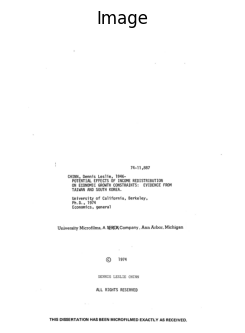

Text:'74-11,887', 'CHINN, Dennis Leslie, 1946-', 'POTENTIAL EFFECTS OF INCOME REDISTRIBUTION', 'ON ECONOMIC GROWTH CONSTRAINTS: EVIDENCE FROM', 'TAIWAN AND SOUTH KOREA.', 'University of California, Berkeley,', 'Ph.D., 1974', 'Economics, general', 'University Microfilms, A XEROX Company Ann Arbor, Michigan', 'C', '1974', 'DENNIS LESLIE CHINN', 'ALL RIGHTS RESERVED', 'THIS DISSERTATION HAS BEEN MICROFILMED EXACTLY AS RECEIVED.'
Label:Label-TitlePage


In [11]:
%matplotlib inline
def visualize(idx):
    current_row = data.iloc[idx]
    image = cv2.imread(current_row['img_path'])
    text = current_row['text']
    label = current_row['class']
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image")
    plt.show()
    
    print(f"Text:{text}")
    print(f"Label:{label}")

random_idx = np.random.choice(len(data))
visualize(random_idx)

In [12]:
data['class'].value_counts()

Label-Appendices         8112
Label-ReferenceList      3230
Label-Other              2363
Label-CurriculumVitae    1980
Label-ChapterAbstract    1386
Label-ListofFigures      1171
Label-TableofContent     1120
Label-ListofTables       1110
Label-Abstract           1094
Label-Acknowledgement    1084
Label-Dedication         1069
Label-TitlePage          1046
Name: class, dtype: int64

## Train, Test and Validation set

In [13]:
# 15% for test
train_df, test_df = train_test_split(
    data, test_size=0.15, stratify=data["class"].values, random_state=42
)
# 25% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df["class"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 15787
Total validation examples: 5263
Total test examples: 3715


In [14]:
train_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [15]:
test_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [16]:
val_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [17]:
train_df['class'].value_counts()

Label-Appendices         5171
Label-ReferenceList      2059
Label-Other              1507
Label-CurriculumVitae    1262
Label-ChapterAbstract     883
Label-ListofFigures       746
Label-TableofContent      714
Label-ListofTables        708
Label-Abstract            697
Label-Acknowledgement     691
Label-Dedication          682
Label-TitlePage           667
Name: class, dtype: int64

In [18]:
test_df['class'].value_counts()

Label-Appendices         1217
Label-ReferenceList       485
Label-Other               354
Label-CurriculumVitae     297
Label-ChapterAbstract     208
Label-ListofFigures       176
Label-TableofContent      168
Label-ListofTables        166
Label-Abstract            164
Label-Acknowledgement     163
Label-Dedication          160
Label-TitlePage           157
Name: class, dtype: int64

In [19]:
val_df['class'].value_counts()

Label-Appendices         1724
Label-ReferenceList       686
Label-Other               502
Label-CurriculumVitae     421
Label-ChapterAbstract     295
Label-ListofFigures       249
Label-TableofContent      238
Label-ListofTables        236
Label-Abstract            233
Label-Acknowledgement     230
Label-Dedication          227
Label-TitlePage           222
Name: class, dtype: int64

In [20]:
# Define TF Hub paths to the BERT encoder and its preprocessor
#'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3'
    
# bert_model_path = (
#     'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/2'
# )
# bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [21]:
# def make_bert_preprocessing_model(sentence_features, seq_length=512):
#     """Returns Model mapping string features to BERT inputs.

#   Args:
#     sentence_features: A list with the names of string-valued features.
#     seq_length: An integer that defines the sequence length of BERT inputs.

#   Returns:
#     A Keras Model that can be called on a list or dict of string Tensors
#     (with the order or names, resp., given by sentence_features) and
#     returns a dict of tensors for input to BERT.
#   """

#     input_segments = [
#         tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
#         for ft in sentence_features
#     ]

#     # Tokenize the text to word pieces.
#     bert_preprocess = hub.load(bert_preprocess_path)
#     tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
#     segments = [tokenizer(s) for s in input_segments]

#     # Optional: Trim segments in a smart way to fit seq_length.
#     # Simple cases (like this example) can skip this step and let
#     # the next step apply a default truncation to approximately equal lengths.
#     truncated_segments = segments

#     # Pack inputs. The details (start/end token ids, dict of output tensors)
#     # are model-dependent, so this gets loaded from the SavedModel.
#     packer = hub.KerasLayer(
#         bert_preprocess.bert_pack_inputs,
#         arguments=dict(seq_length=seq_length),
#         name="packer",
#     )
#     model_inputs = packer(truncated_segments)
#     return keras.Model(input_segments, model_inputs)

In [22]:
# bert_preprocess_model = make_bert_preprocessing_model(['text'])
# #keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

2023-05-20 03:03:59.493181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1c:00.0, compute capability: 7.0


In [20]:
def dataframe_to_dataset(dataframe):
    columns = ["img_path", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [21]:
resize = (224, 224)
# bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

from keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image_path):

    img_path = tf.io.read_file(image_path)
    image_decode = tf.image.decode_png(img_path, 3)
    image = tf.image.resize(image_decode, resize)
    return image


# def preprocess_text(text):
#     text = tf.convert_to_tensor([text])
#     output = bert_preprocess_model([text])
#     output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
#     return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["img_path"])
    return {"image": image_1}

In [22]:
# example of progressively loading data
batch_size = 8
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [23]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

2023-05-31 15:17:22.259650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [24]:
train_ds

<PrefetchDataset element_spec=({'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
def separate_labels(ds):
    labels = []
    for _, label in tqdm(ds.unbatch(), desc = 'Progress Bar'):
        labels.append(label)
    labels = np.array(labels)
    return labels

In [26]:
print('####### Separating Test Labels ##############')
test_labels = separate_labels(test_ds)

####### Separating Test Labels ##############


Progress Bar: 3715it [00:40, 90.64it/s] 


## Projection Configuration

In [27]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

## Vision Encoder

In [28]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)

    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    # embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

## Text Encoder

In [35]:
# def create_text_encoder(
#     num_projection_layers, projection_dims, dropout_rate, trainable=False
# ):
#     # Load the pre-trained BERT model to be used as the base encoder.
#     bert = hub.KerasLayer(bert_model_path, name="bert",)
#     # Set the trainability of the base encoder.
#     bert.trainable = trainable

#     # Receive the text as inputs.
#     bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
#     inputs = {
#         feature: keras.Input(shape=(512,), dtype=tf.int32, name=feature)
#         for feature in bert_input_features
#     }

#     # Generate embeddings for the preprocessed text using the BERT model.
#     embeddings = bert(inputs)["pooled_output"]

#     # Project the embeddings produced by the model.
#     outputs = project_embeddings(
#         embeddings, num_projection_layers, projection_dims, dropout_rate
#     )
#     # Create the text encoder model.
#     return keras.Model(inputs, outputs, name="text_encoder")

## Multimodal

In [30]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention = False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image")

    # # Receive the text as inputs.
    # bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    # text_inputs = {
    #     feature: keras.Input(shape=(512,), dtype=tf.int32, name=feature)
    #     for feature in bert_input_features
    # }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    # text_encoder = create_text_encoder(
    #     num_projection_layers, projection_dims, dropout_rate, text_trainable
    # )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    #text_projections = text_encoder(text_inputs)
    
    # Cross attention
    if attention:
        query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.8)(
            [vision_projections, text_projections]
        )
    
    # Dropout
    vision_projections = keras.layers.Dropout(0.8)(vision_projections)
    #text_projections = keras.layers.Dropout(0.8)(text_projections)

    # Concatenate the projections and pass through the classification layer.
    #concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    # if attention:
    #     concatenated = keras.layers.Concatenate()([concatenated, query_value_attention_seq])
    outputs = keras.layers.Dense(12, activation="softmax")(vision_projections)
    return keras.Model([image_1], outputs)


multimodal_model = create_multimodal_model(attention=False)
multimodal_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 256)              24155648  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                                 
Total params: 24,158,732
Trainable params: 593,932
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
EPOCHS = 40
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=0.001, decay_steps=train_ds.cardinality() * EPOCHS
# )
optimizer = tf.keras.optimizers.Adam(
    decay=0.004, epsilon=1e-07, clipvalue=2.0, learning_rate=0.001)

multimodal_model.compile(
    optimizer=optimizer, loss=SparseCategoricalFocalLoss(gamma=2), metrics="accuracy"
)

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('multimodal_resNET50BERT_minority-4.h5', monitor='val_loss', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

In [34]:
start = time.time()
with tf.device('/device:GPU:0'):
    history = multimodal_model.fit(train_ds, validation_data=validation_ds, callbacks=[es, checkpoint], epochs=EPOCHS)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/40


2023-05-31 15:22:29.057777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1974/1974 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.5097
Epoch 1: val_loss improved from inf to 0.57349, saving model to multimodal_resNET50BERT_minority-4.h5
1974/1974 [==============================] - 254s 117ms/step - loss: 1.2002 - accuracy: 0.5097 - val_loss: 0.5735 - val_accuracy: 0.6958
Epoch 2/40
1974/1974 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.6412
Epoch 2: val_loss improved from 0.57349 to 0.50921, saving model to multimodal_resNET50BERT_minority-4.h5
1974/1974 [==============================] - 41s 21ms/step - loss: 0.6900 - accuracy: 0.6412 - val_loss: 0.5092 - val_accuracy: 0.7237
Epoch 3/40
1971/1974 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.6754
Epoch 3: val_loss improved from 0.50921 to 0.47192, saving model to multimodal_resNET50BERT_minority-4.h5
1974/1974 [==============================] - 40s 20ms/step - loss: 0.6065 - accuracy: 0.6756 - val_loss: 0.4719 - val_accuracy: 0.7

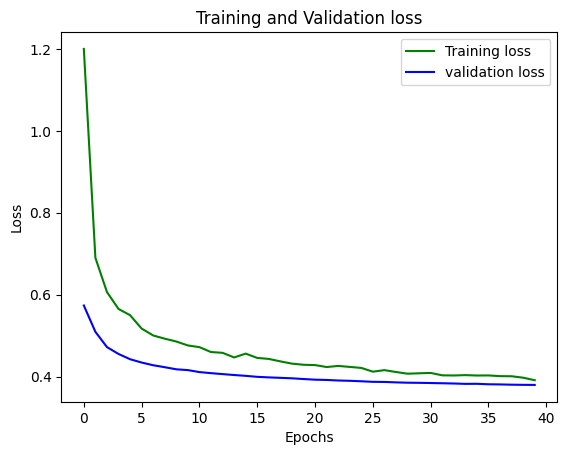

In [35]:
loss_val = history.history['val_loss']
loss_train = history.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

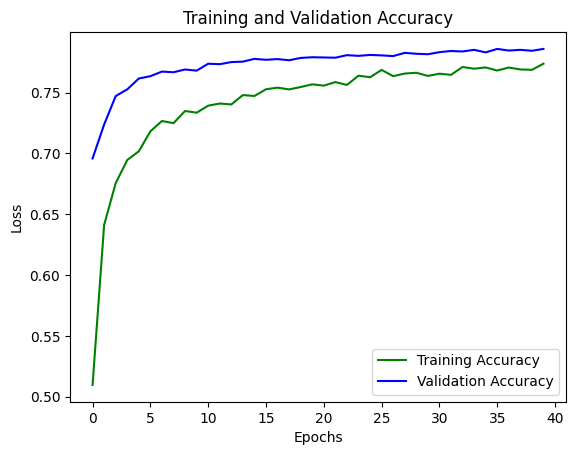

In [36]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
#model = keras.models.load_weights('multimodal_resNET50BERT_minority-3.h5')

In [44]:
multimodal_model.load_weights('multimodal_resNET50BERT_minority-4.h5')

In [40]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

465/465 [==============================] - 7s 14ms/step - loss: 0.3906 - accuracy: 0.7825
Accuracy on the test set: 78.25%.


In [41]:
class_names = list(label_map.keys())
def detailed_test_eval(model):
    prediction_labels = np.argmax(model.predict(test_ds), 1)
    print(classification_report(test_labels, prediction_labels, target_names=class_names))
    result = pd.DataFrame(confusion_matrix(test_labels, prediction_labels),
                        index=class_names, columns=class_names)
    result.to_csv('ETDSeg_confusion-matrix-3.csv')
    return result

In [42]:
detailed_test_eval(multimodal_model)

465/465 [==============================] - 6s 12ms/step
                       precision    recall  f1-score   support

     Label-Appendices       0.74      0.87      0.80      1217
  Label-ReferenceList       0.81      0.84      0.83       485
          Label-Other       0.64      0.41      0.50       354
 Label-TableofContent       0.77      0.75      0.76       168
      Label-TitlePage       0.88      0.88      0.88       157
       Label-Abstract       0.56      0.45      0.50       164
  Label-ListofFigures       0.70      0.66      0.68       176
Label-Acknowledgement       0.73      0.63      0.68       163
   Label-ListofTables       0.80      0.70      0.75       166
Label-CurriculumVitae       0.92      0.96      0.94       297
     Label-Dedication       0.99      0.91      0.95       160
Label-ChapterAbstract       0.99      0.95      0.97       208

             accuracy                           0.78      3715
            macro avg       0.79      0.75      0.77      37

,Label-Appendices,Label-ReferenceList,Label-Other,Label-TableofContent,Label-TitlePage,Label-Abstract,Label-ListofFigures,Label-Acknowledgement,Label-ListofTables,Label-CurriculumVitae,Label-Dedication,Label-ChapterAbstract
Label-Appendices,1055,46,54,8,5,21,5,8,3,12,0,0
Label-ReferenceList,60,406,1,0,0,4,6,3,1,3,1,0
Label-Other,151,11,144,7,12,14,6,4,3,2,0,0
Label-TableofContent,25,1,1,126,1,0,10,0,4,0,0,0
Label-TitlePage,12,0,6,1,138,0,0,0,0,0,0,0
Label-Abstract,47,7,11,0,1,74,1,17,0,6,0,0
Label-ListofFigures,15,12,0,14,0,0,117,1,16,1,0,0
Label-Acknowledgement,31,6,5,0,0,14,0,103,0,1,0,3
Label-ListofTables,12,7,0,7,0,1,22,0,116,1,0,0
Label-CurriculumVitae,4,3,0,0,0,0,0,3,2,285,0,0
